In [17]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [18]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [19]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [20]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'tuning_breakdown'

In [21]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [22]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [80]:

all_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
odor_pre_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
odor_post_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
odor_pre_rev_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'
odor_post_rev_animals = 'c3f3', 'c3f2', 'c3m1', 'c3m2', 'c4m4', 'c10m6', 'c10m8', '90', '91', '92', '93'

In [81]:
sessions = '3odor_pre', '3odor_post', '3odor_pre_rev', '3odor_post_rev',

In [86]:
i=0;
sess_without = 'odor_pre', 'odor_post', 'odor_pre_rev', 'odor_post_rev',
for sess in sessions:
    exec('selectivity_%s = {}'%sess_without[i])
    for ani in eval('%s_animals'%sess_without[i]):
        try:
            eval('selectivity_%s'%sess_without[i]).update({ani: ut.load_variable('selectivity', '../%s/%s/notebooks/autorestore/selectivity/'%(ani, sess))})
        except IOError:
            continue
    i=i+1

In [87]:
sess_reg = ['pre', 'post', 'pre_rev', 'post_rev']

for s1, s2 in product(sess_reg, repeat=2):
    if s1==s2:
        continue
    exec("cellregs_%sVS%s = {}"%(s1, s2))
    for ani in all_animals:
        try:
            eval("cellregs_%sVS%s"%(s1, s2)).update({ani:ut.load_variable('cellregs',
                                                '../%s/notebooks/autorestore/decoding_%sVS%s'%(ani, s1, s2))})
        except:
            pass
    print len(eval("cellregs_%sVS%s"%(s1, s2))), s1, s2

9 pre post
0 pre pre_rev
0 pre post_rev
0 post pre
0 post pre_rev
9 post post_rev
0 pre_rev pre
0 pre_rev post
0 pre_rev post_rev
0 post_rev pre
0 post_rev post
0 post_rev pre_rev


In [88]:
def extract_tuned(selectivity, which_odor, p=0.05, adjust=True):
    pvs = np.r_[[s[0][-1] for s in selectivity[which_odor]]]
    if adjust:
        pvs = ut.adjust_pvalues(pvs)
    return pvs<p

In [101]:
for sess in sess_without:
    exec('tuned_%s_csm = {}'%sess)
    exec('tuned_%s_csp = {}'%sess)
    exec('tuned_%s_sh = {}'%sess)
    for ani in eval('%s_animals'%sess):
        try:
            eval('tuned_%s_csm'%sess).update({ani:extract_tuned(eval('selectivity_%s'%sess)[ani], 'CSmt_tr')})
            eval('tuned_%s_csp'%sess).update({ani:extract_tuned(eval('selectivity_%s'%sess)[ani], 'rewardt_tr')})
            eval('tuned_%s_sh'%sess).update({ani:extract_tuned(eval('selectivity_%s'%sess)[ani], 'sht_tr')})
        except IOError:
            continue
    exec("tuned_%s_csm = np.concatenate([eval('tuned_%s_csm')[ani]\
                                         for ani in eval('%s_animals')])"%(sess, sess, sess))
    exec("tuned_%s_csp = np.concatenate([eval('tuned_%s_csp')[ani]\
                                         for ani in eval('%s_animals')])"%(sess, sess, sess))
    exec("tuned_%s_sh = np.concatenate([eval('tuned_%s_sh')[ani]\
                                         for ani in eval('%s_animals')])"%(sess, sess, sess))
        

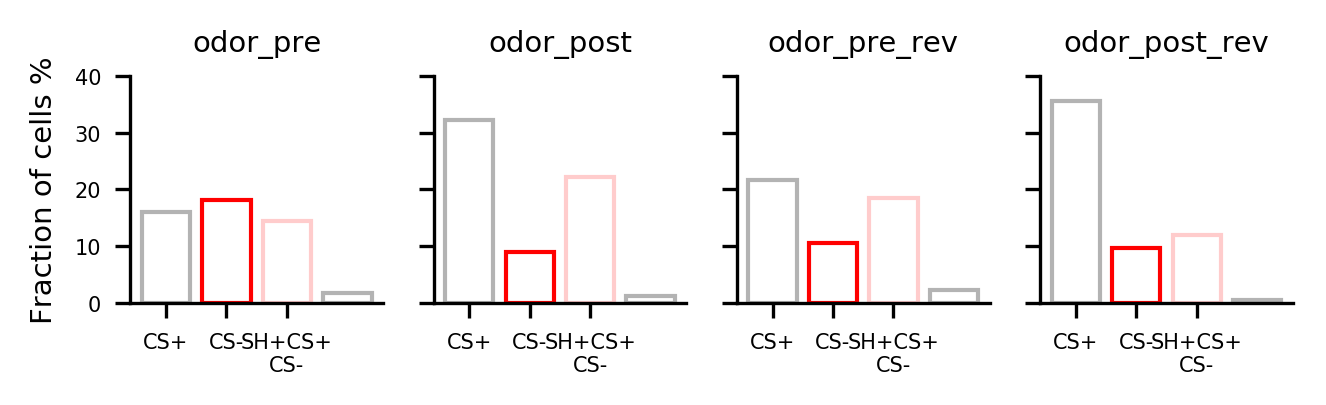

In [102]:
fig, axs = pl.subplots(1, 4, figsize=(5, 1), sharex=True, sharey=True)

n = len(tuned_odor_pre_csp)

for ax, sess in zip(axs, sess_without):

    values = [100.*eval('tuned_%s_csp'%sess).sum()/n,
              100.*eval('tuned_%s_csm'%sess).sum()/n,
              100.*eval('tuned_%s_sh'%sess).sum()/n,
              100.*(eval('tuned_%s_csp'%sess)*eval('tuned_%s_csm'%sess)*eval('tuned_%s_sh'%sess)).sum()/n,]
    pt.plot_bars(values, ax=ax, colors=['0.7', 'r', (1, 0.8, 0.8)])

    ax.set_title(sess)
    
for ax in axs:
    ax.set_ylim(0, 40)
    ax.set_xticks(range(3))
    ax.set_xticklabels(['CS+', 'CS-', 'SH+' 'CS+\nCS-'])
    
axs[0].set_ylabel('Fraction of cells %')

# above is for cellReg cells

In [103]:
np.mean([1460, 729, 985,1253, 1068, 1049])

1090.6666666666667

In [104]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'os'. Skipping...
